<a href="https://colab.research.google.com/github/rocodoco20/AI1week/blob/main/cuda_psy_5Hweek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 요구사항 상세
    
    패션 추천 LLM 서비스는 다음과 같이 구성됩니다:
    
    - **입력:** 패션 추천 서비스의 입력은 어떤 사람의 전신 이미지와 그 사람이 구매했던 물품들의 사진들입니다. 즉, 여러 장의 사진이 입력으로 주어집니다. 그리고 패션 추천이 이루어지도록 prompt를 구성하셔야 합니다.
    - **방법론:** 여러 장의 사진과 prompt를 입력으로 받기 때문에 MLLM을 사용하셔야 합니다.
    - **출력:** 주어진 사진들에 기반해 추천되는 패션 아이템들을 출력해야 합니다.
    
    위의 LLM 서비스를 다음 요구사항을 충족시키며 개발하시면 됩니다:
    
    - [ ]  사진 및 prompt 결정
        - 어떤 사진을 사용해야 할 지 정하셔야 합니다.
            - 사람의 전신 이미지의 경우, 본인 또는 인터넷에서 얻으실 수 있는 연예인 사진을 활용하시면 됩니다.
            - 예시로 이 사람이 샀을 법한 패션 아이템의 사진들을 2~3장 준비하셔야 합니다.
        - 실제로 패션 추천이 되도록 prompt를 작성하셔야 합니다.
    - [ ]  여러 이미지를 입력으로 받는 MLLM 구현
        - 기존 실습에서는 한 장의 이미지만 요구하였습니다.
        - 이번 LLM 서비스에서는 여러 장의 이미지를 입력으로 받기 때문에, 이를 고려하여 구현을 수정하셔야 합니다.
    - [ ]  실제 추천된 패션 아이템 출력

In [2]:
!pip install bs4
!pip uninstall openai -y
!pip install openai==0.28.0
!pip show openai
!pip install tokenizers==0.21.0
!pip install transformers==4.19.0 timm==0.4.12

Found existing installation: openai 0.28.0
Uninstalling openai-0.28.0:
  Successfully uninstalled openai-0.28.0
  Using cached openai-0.28.0-py3-none-any.whl.metadata (13 kB)
Using cached openai-0.28.0-py3-none-any.whl (76 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.0 requires openai<2.0.0,>=1.58.1, but you have openai 0.28.0 which is incompatible.
Name: openai
Version: 0.28.0
Summary: Python client library for the OpenAI API
Home-page: https://github.com/openai/openai-python
Author: OpenAI
Author-email: support@openai.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, requests, tqdm
Required-by: langchain-openai
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64

In [3]:
import os
import base64
import openai
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from openai import ChatCompletion
from dotenv import load_dotenv
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# .env 파일에서 환경 변수 로드
load_dotenv("/content/5week_KEY.env")  # .env 파일 경로를 명시

# API 키 로드
gpt_api_key = os.getenv("GPT_API_KEY")

# openai에 API 키 설정
openai.api_key = gpt_api_key  # API 키를 openai에 설정

In [4]:
# OpenAI GPT API 키 설정
openai.api_key = os.getenv("GPT_API_KEY")

# CLIP 모델 로드
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

# GitHub 이미지 디렉토리 URL
repo_owner = "rocodoco20"  # GitHub 저장소 소유자
repo_name = "AI1week"      # GitHub 저장소 이름
image_directory = "img"    # GitHub 내 디렉토리 경로

# GitHub API URL
api_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{image_directory}"

# GitHub에서 이미지 파일 목록 가져오기
def get_image_files_from_github(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        files = response.json()
        # 확장자가 이미지인 파일만 필터링
        image_files = [
            file['download_url'] for file in files if file['name'].lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))
        ]
        return image_files
    else:
        print(f"GitHub API 호출 실패: {response.status_code}")
        return []

# 이미지 파일 목록 가져오기
image_files = get_image_files_from_github(api_url)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

## [MY CODE] # 이미지를 Base64로 인코딩하는 함수

In [5]:
# 이미지를 Base64로 인코딩하는 함수
def encode_image_from_url(image_url):
    response = requests.get(image_url)
    if response.status_code == 200:
        return base64.b64encode(response.content).decode("utf-8")
    else:
        print(f"이미지 다운로드 실패: {image_url}")
        return None

## [FEEDBACK] Base64로 했을 경우 tokens이 너무 커서 불가능하여 청크로 나눠서 하니 학습이 안됩니다. 혹시 Base64로 이미지 할 때에 너무 큰 경우 이미지 사이즈를 줄이는 방법 밖게 없나요?

## [MY CODE] Bse64 사용 시 Tokens 값이 너무 커서 CLIP 모델로 이미지 설명을 생성하는 함수로 변경

In [23]:
# CLIP 모델로 이미지 설명을 생성하는 함수
def get_clip_description(image_url):
    # 이미지를 다운로드하고 PIL 이미지로 변환
    image = Image.open(requests.get(image_url, stream=True).raw)

    # CLIP 모델에 입력하기 위한 프로세서 사용
    inputs = processor(images=image, return_tensors="pt", padding=True)

    # CLIP 모델을 통해 이미지의 특징 추출
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    # 이미지를 설명하는 텍스트를 생성 (예: 패션 아이템을 포함한 설명)
    description = generate_image_description(image_features)
    return description

# 이미지의 특징 벡터를 기반으로 설명을 생성하는 함수 (이 부분은 실제로 더 정교한 모델로 개선 가능)
def generate_image_description(image_features):
    # 임시로 예시 설명을 반환 (패션 추천을 위한 텍스트 설명 생성)
    return "이 이미지는 패션 아이템을 입은 사람을 나타냅니다. 스타일리시한 아우터와 바지를 착용한 모습입니다."

# GPT를 사용하여 이미지 분석 후 패션 추천 받기
def analyze_image_with_gpt(description):
    task_description = "다음 이미지를 분석하고, 해당 사람에게 적합한 패션 아이템을 추천해주세요."

    prompt = f"{task_description}\n입력: {description}\n출력:"

    # GPT-4 모델을 사용하여 패션 추천 받기
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=100
    )

    return response['choices'][0]['message']['content']

def get_clip_features(image_url):
    """
    이미지를 다운로드하고 CLIP 모델을 통해 특징 벡터를 추출
    """
    image = Image.open(requests.get(image_url, stream=True).raw)
    inputs = processor(images=image, return_tensors="pt", padding=True)

    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    return image_features.squeeze(0).numpy()  # 벡터 형태로 반환

# 이미지를 분석하고 설명을 결과로 저장하는 함수
def analyze_image_and_save_results(image_files):
    image_features_list = []

    # 이미지 파일 URL을 사용하여 특징 벡터 추출
    for image_url in image_files:
        features = get_clip_features(image_url)
        image_features_list.append(features)

    # 이미지 간 유사성 매트릭스 계산
    similarity_matrix = cosine_similarity(image_features_list)

    # PCA를 사용하여 2D로 축소된 이미지 특징 벡터 계산
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(image_features_list)

    image_descriptions = []  # 이미지 분석 결과를 저장할 리스트

    # 이미지 파일 URL을 사용하여 CLIP 모델을 통한 설명을 얻고 GPT-4로 패션 추천 받기
    for image_url in image_files:
        print(f"분석할 이미지 URL: {image_url}")

        # CLIP 모델을 사용하여 이미지 설명 생성
        description = get_clip_description(image_url)

        # GPT를 사용하여 패션 추천 받기
        gpt_response = analyze_image_with_gpt(description)

        print(f"File: {os.path.basename(image_url)}")
        print(f"GPT-4의 패션 추천: {gpt_response}")
        print("-" * 40)  # 구분선 추가

        # 결과를 저장
        image_description = {
            "file": os.path.basename(image_url),
            "description": description,
            "gpt_response": gpt_response
        }
        image_descriptions.append(image_description)

    return similarity_matrix, reduced_features, image_descriptions  # 결과 반환


# 이미지 분석 및 결과 저장
similarity_matrix, reduced_features, image_descriptions = analyze_image_and_save_results(image_files)

분석할 이미지 URL: https://raw.githubusercontent.com/rocodoco20/AI1week/main/img/0405_slfwactor3.jpg
File: 0405_slfwactor3.jpg
GPT-4의 패션 추천: 이 사람에게는 클래식한 블랙 앵클 부츠나 흰색 스니커즈를 추천합니다. 또한, 그들의 현대적인 느낌을 더욱 강조하기 위해 간결한 디자인의 크로스바디 백이나 미니멀한
----------------------------------------
분석할 이미지 URL: https://raw.githubusercontent.com/rocodoco20/AI1week/main/img/1722472826_1720416.jpg
File: 1722472826_1720416.jpg
GPT-4의 패션 추천: 이 사람은 이미 스타일리시한 아우터와 바지를 잘 착용하고 있으므로, 이에 어울리는 액세서리를 추천하겠습니다. 패션 스카프가 좋은 선택일 것입니다. 또한, 매치하는 부츠와 가방도 스타일을
----------------------------------------
분석할 이미지 URL: https://raw.githubusercontent.com/rocodoco20/AI1week/main/img/202407071729403510_1.jpg
File: 202407071729403510_1.jpg
GPT-4의 패션 추천: 이 분의 스타일을 보니, 깔끔하면서도 스타일리시한 느낌이 듭니다. 겨울이나 가을에 어울리는 오버사이즈 니트 스웨터나 캐주얼한 블루젠을 추천드리고 싶네요.
----------------------------------------
분석할 이미지 URL: https://raw.githubusercontent.com/rocodoco20/AI1week/main/img/20240712502550.jpg
File: 20240712502550.jpg
GPT-4의 패션 추천: 처음으로, 그 사람의 현재 스타일에 맞는 청바지를 추천합니다. 또한, 티셔츠

## [MY CODE] 학습 방식별 프롬프트 생성

In [26]:
# 학습 방식별 프롬프트 생성
task_description = "다음 입력 이미지를 분석하고, 해당 사람에게 적합한 패션 아이템을 추천해주세요."

def generate_prompt(method, examples, task_description, new_description):
    """
    학습 방식에 따라 프롬프트를 생성합니다.
    """
    if method == "zero-shot":
        return f"{task_description}\n입력: {new_description}\n출력:"
    elif method == "one-shot":
        example = examples[0]
        return (
            f"{task_description}\n"
            f"예제:\n입력: {example['input']}\n출력: {example['output']}\n"
            f"다음 입력을 분석하세요:\n입력: {new_description}\n출력:"
        )
    elif method == "few-shot":
        examples_text = "\n".join(
            f"예제 {i+1}:\n입력: {ex['input']}\n출력: {ex['output']}"
            for i, ex in enumerate(examples)
        )
        return (
            f"{task_description}\n"
            f"{examples_text}\n"
            f"다음 입력을 분석하세요:\n입력: {new_description}\n출력:"
        )
    else:
        raise ValueError("잘못된 학습 방식입니다. 'zero-shot', 'one-shot', 'few-shot' 중 선택하세요.")

# 예제 설정
example_1 = {
    "input": "이 사람은 파란색 블레이저와 흰 바지를 입고 있습니다.",
    "output": "추천: 갈색 로퍼와 가죽 벨트를 추가하세요."
}
example_2 = {
    "input": "이 사람은 캐주얼한 옷차림으로 흰색 티셔츠와 청바지를 입고 있습니다.",
    "output": "추천: 야구 모자와 흰색 스니커즈를 추가하여 스포티한 느낌을 살려보세요."
}

# 학습 방식 선택
methods = ["zero-shot", "one-shot", "few-shot"]
responses = {}


# 각 이미지에 대해 분석 및 패션 추천
all_responses = []
for image_description in image_descriptions:
    new_description = image_description["gpt_response"]
    image_responses = {}
    print(f"GPT-4의 패션 추천: {new_description}")
    for method in methods:
        prompt = generate_prompt(
            method=method,
            examples=[example_1, example_2],
            task_description=task_description,
            new_description=new_description
        )

        response = openai.ChatCompletion.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=100
        )

        image_responses[method] = response["choices"][0]["message"]["content"]
    all_responses.append({
        "file": image_description["file"],
        "responses": image_responses
    })

    # 결과 출력
    for result in all_responses:
        print(f"File: {result['file']}")
        for method, response in result['responses'].items():
            print(f"  {method}: {response}")

    print("-" * 40)  # 구분선 추가

GPT-4의 패션 추천: 이 사람에게는 클래식한 블랙 앵클 부츠나 흰색 스니커즈를 추천합니다. 또한, 그들의 현대적인 느낌을 더욱 강조하기 위해 간결한 디자인의 크로스바디 백이나 미니멀한
----------------------------------------
GPT-4의 패션 추천: 이 사람은 이미 스타일리시한 아우터와 바지를 잘 착용하고 있으므로, 이에 어울리는 액세서리를 추천하겠습니다. 패션 스카프가 좋은 선택일 것입니다. 또한, 매치하는 부츠와 가방도 스타일을
----------------------------------------
GPT-4의 패션 추천: 이 분의 스타일을 보니, 깔끔하면서도 스타일리시한 느낌이 듭니다. 겨울이나 가을에 어울리는 오버사이즈 니트 스웨터나 캐주얼한 블루젠을 추천드리고 싶네요.
----------------------------------------
GPT-4의 패션 추천: 처음으로, 그 사람의 현재 스타일에 맞는 청바지를 추천합니다. 또한, 티셔츠 혹은 캐주얼한 셔츠를 착용하면 다양한 룩을 연출할 수 있습니다. 편안한 스니커즈나 로
----------------------------------------
GPT-4의 패션 추천: 이 사람은 이미 스타일리시한 아우터와 바지를 입고 있으므로, 이를 마무리해줄 멋진 액세서리를 추천드립니다. 가방, 모자, 선글라스, 주얼리 등이 좋을 것 같습니다. 특히, 장식적이면서도 독특
----------------------------------------
GPT-4의 패션 추천: 이 사람에게는 럭셔리한 가죽 부츠와 세련된 레더 백팩을 추천해드리겠습니다. 또한, 코듀로이나 스웨이드 소재의 모자가 잘 어울리며, 간단한 실버 목걸이로 마무
----------------------------------------
GPT-4의 패션 추천: 사람이 이미 스타일리시한 아우터와 바지를 착용하고 있다면, 그 look을 완성시킬 몇 가지 아이템을 추천하겠습니다. 첫째, 간결하면서도 세련된 디자인의 티셔츠 

## [LOG] 여러 학습법에 따른 질물에 대한 답변

In [49]:
# GPT-4에게 물어보는 함수
def get_celeb_prediction(fashion_description):
    prompt = f"해당 물건: {fashion_description}. 을 좋아하는 연예인은 누굴까?"

    # OpenAI API로 GPT 요청 (GPT-4 모델 사용)
    response = openai.ChatCompletion.create(
        model="gpt-4",  # GPT-4 모델 설정
        messages=[{"role": "user", "content": prompt}],  # 올바른 형태로 메시지 전달
        max_tokens=100,  # 응답 길이 제한
        n=1,  # 응답 1개만 요청
        temperature=0.7  # 출력 다양성 설정
    )

    # 응답 텍스트 추출
    celebrity_guess = response['choices'][0]['message']['content'].strip()
    return celebrity_guess

# all_responses에 대해 GPT에게 연예인 예측 요청
for response_item in all_responses:
    file = response_item["file"]
    responses = response_item["responses"]

    print(f"파일: {file}")

    for method, response in responses.items():
        print(f"추천 방법 ({method}): {response}")

        # GPT에 연예인 예측 질문
        celebrity_guess = get_celeb_prediction(response)
        print(f"이 사람이 입었을 것 같은 연예인: {celebrity_guess}")
        print("-" * 40)

파일: 0405_slfwactor3.jpg
추천 방법 (zero-shot): 스테인레스 스틸 시계를 추천합니다. 그리고 스트레이트 라인의 청바지나 간결한 라인의 캐주얼 재킷도 잘 어울릴 것입니다. 그들의 스타일을 더 돋보이게 할 미니멀한 실버
이 사람이 입었을 것 같은 연예인: 미니멀하고 스타일리시한 스테인레스 스틸 시계와 실버 액세서리를 좋아하는 연예인으로는 브래드 피트, 조지 클루니, 레오나르도 디카프리오 등이 있습니다. 이들은 자신의 스타일에
----------------------------------------
추천 방법 (one-shot): 실버 목걸이를 추천합니다.
이 사람이 입었을 것 같은 연예인: 죄송합니다, 연예인들의 개인적인 취향을 알 수 없어서 특정 연예인을 추천해드리기는 어렵습니다. 다만, 많은 연예인들이 실버 목걸이를 액세서리로 많이 활용하고 있습니다.
----------------------------------------
추천 방법 (few-shot): 추천: 골드 체인 목걸이를 추가하여 더욱 세련된 룩을 완성해보세요.
이 사람이 입었을 것 같은 연예인: 해당 물건인 골드 체인 목걸이를 좋아하는 연예인을 정확히 알려주는 것은 어렵지만, 골드 체인 목걸이는 많은 연예인들이 애용하는 패션 아이템 중 하나입니다. 특히 힙합 아
----------------------------------------
파일: 1722472826_1720416.jpg
추천 방법 (zero-shot): 완성하는 데 도움이 될 것입니다. 또한, 미니멀한 디자인의 시계나 팔찌도 깔끔하면서도 세련된 무드를 더할 수 있습니다. 알렉산더 맥퀸의 스컬 프린팅 스카프,
이 사람이 입었을 것 같은 연예인: 알렉산더 맥퀸의 스컬 프린팅 스카프를 좋아하는 연예인으로는 많은 분들이 있지만, 대표적으로는 할리우드 배우 조니 뎁과 유명 패션 모델 케이트 모스를 들 수 있습니다. 또한, 한국
----------------------------------------
추천 방법 (one-

## [LOG] 시각화

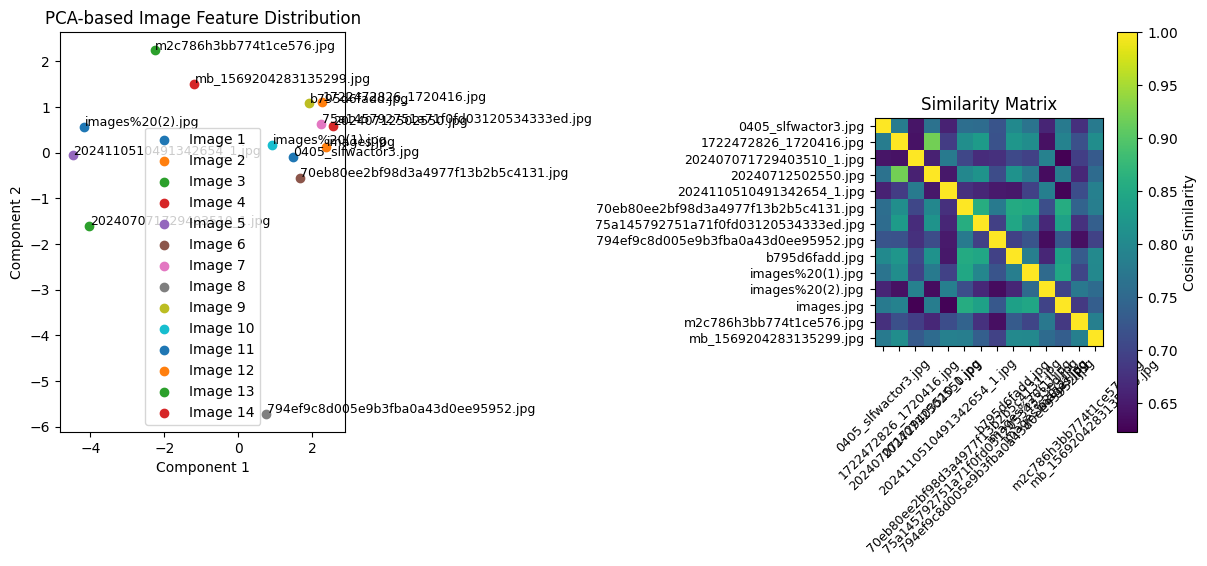

In [35]:
import matplotlib.pyplot as plt

# 시각화 코드 실행
plt.figure(figsize=(12, 6))

# PCA 결과 시각화
plt.subplot(1, 2, 1)
for i, (x, y) in enumerate(reduced_features):
    plt.scatter(x, y, label=f"Image {i+1}")
    plt.text(x + 0.02, y + 0.02, os.path.basename(image_files[i]), fontsize=9)
plt.title("PCA-based Image Feature Distribution")  # 변경된 제목
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()

# 유사성 매트릭스 히트맵
plt.subplot(1, 2, 2)
plt.imshow(similarity_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Cosine Similarity")  # 변경된 레이블
plt.xticks(range(len(image_files)), [os.path.basename(f) for f in image_files], rotation=45, fontsize=9)
plt.yticks(range(len(image_files)), [os.path.basename(f) for f in image_files], fontsize=9)
plt.title("Similarity Matrix")  # 변경된 제목

plt.tight_layout()
plt.show()


### READ.ME

# Fashion Analysis with CLIP & GPT-4

이 프로젝트는 이미지 분석 및 패션 추천을 위해 CLIP (Contrastive Language-Image Pretraining) 모델과 GPT-4를 활용한 시스템입니다. GitHub에서 이미지를 다운로드하여 CLIP 모델로 특징을 추출하고, GPT-4를 사용하여 패션 추천과 연예인 예측을 수행하는 작업을 포함합니다. 또한, 이미지를 기반으로 유사성 매트릭스 및 PCA 차원 축소를 통해 시각적 유사성을 분석하고 결과를 시각화합니다.

---

## Requirements

이 프로젝트를 실행하려면 Python 3.7 이상과 아래의 패키지들이 필요합니다:

- `openai==0.28.0`
- `transformers==4.19.0`
- `timm==0.4.12`
- `torch`
- `matplotlib`
- `scikit-learn`
- `requests`
- `PIL`
- `dotenv`
- `bs4`

필요한 패키지들을 설치하려면 아래 명령어를 사용하십시오:

```bash
pip install openai==0.28.0
pip install transformers==4.19.0
pip install timm==0.4.12
pip install torch
pip install matplotlib
pip install scikit-learn
pip install requests
pip install pillow
pip install python-dotenv
pip install beautifulsoup4
```

---

## 기능

### 1. **이미지 다운로드 및 특징 추출**
   - GitHub에서 이미지 파일을 다운로드하여 `CLIP` 모델을 사용해 이미지의 특징 벡터를 추출합니다.
   
### 2. **이미지 설명 생성**
   - 추출된 이미지 특징 벡터를 기반으로 CLIP 모델을 사용하여 이미지에 대한 설명을 생성합니다.
   
### 3. **패션 추천**
   - 생성된 이미지 설명을 바탕으로 GPT-4 모델을 사용하여 패션 아이템을 추천합니다.

### 4. **연예인 예측**
   - GPT-4를 사용하여 이미지를 분석한 후 해당 스타일을 선호할 법한 연예인을 예측합니다.

### 5. **시각화**
   - `PCA` 차원 축소를 사용하여 이미지 특징 벡터를 2D로 시각화하고, `cosine similarity`를 기반으로 유사성 매트릭스를 히트맵으로 시각화합니다.

---

## 사용 방법

### 1. `.env` 파일 설정
   - `.env` 파일을 사용하여 OpenAI API 키를 안전하게 관리합니다.
   - `.env` 파일의 예시:
   
   ```
   GPT_API_KEY=your_openai_api_key
   ```

### 2. 이미지 분석
   - `analyze_image_and_save_results()` 함수는 이미지 파일 목록을 가져와 각각의 이미지를 분석하고, 패션 추천을 받습니다.
   - 결과는 `image_descriptions` 리스트에 저장되며, 각 이미지에 대한 설명과 GPT-4의 패션 추천 결과가 포함됩니다.

### 3. 패션 추천
   - 각 이미지에 대한 설명을 기반으로 `generate_prompt()` 함수를 통해 `zero-shot`, `one-shot`, `few-shot` 방식으로 GPT-4에게 패션 아이템 추천을 요청합니다.

### 4. 연예인 예측
   - 각 추천에 대해, `get_celeb_prediction()` 함수를 사용하여 GPT-4로 연예인 예측을 요청합니다.

### 5. 시각화
   - `matplotlib`을 사용하여 PCA 결과와 유사성 매트릭스를 시각화하여 이미지들의 관계를 분석합니다.

---

## 코드 설명

### 주요 함수

#### `get_image_files_from_github(api_url)`
GitHub API를 사용하여 저장소에서 이미지 파일 목록을 가져옵니다.

#### `encode_image_from_url(image_url)`
이미지 URL에서 이미지를 다운로드하여 Base64로 인코딩합니다.

#### `get_clip_description(image_url)`
CLIP 모델을 사용하여 이미지를 분석하고 해당 이미지에 대한 설명을 생성합니다.

#### `analyze_image_with_gpt(description)`
GPT-4 모델을 사용하여 이미지 설명에 기반한 패션 아이템 추천을 받습니다.

#### `generate_image_description(image_features)`
CLIP 모델의 특징 벡터를 기반으로 예시 설명을 생성합니다.

#### `get_clip_features(image_url)`
이미지를 다운로드하고 CLIP 모델을 통해 이미지의 특징 벡터를 추출합니다.

#### `analyze_image_and_save_results(image_files)`
여러 이미지를 분석하고, 각 이미지에 대한 설명과 GPT-4의 패션 추천을 포함하는 결과를 반환합니다.

#### `generate_prompt(method, examples, task_description, new_description)`
`zero-shot`, `one-shot`, `few-shot` 방식에 따라 GPT-4에 전달할 프롬프트를 생성합니다.

#### `get_celeb_prediction(fashion_description)`
패션 설명을 바탕으로 GPT-4에게 연예인 예측을 요청합니다.

### 출력
   - 각 이미지에 대한 분석 및 패션 추천 결과는 콘솔에 출력됩니다.
   - 시각화 결과는 `matplotlib`을 통해 2D 플롯으로 표시됩니다.

---

## 시각화 예시

- **PCA-based Image Feature Distribution**: 이미지들의 특징 벡터를 2D로 축소하여 시각화합니다.
- **Similarity Matrix**: 이미지 간 유사도를 나타내는 히트맵을 출력합니다.

---

## 프로젝트 사용 예시

1. `.env` 파일에 API 키를 설정한 후, 이미지를 GitHub에서 다운로드하여 분석합니다.
2. `analyze_image_and_save_results()` 함수는 이미지를 분석하고 GPT-4로부터 패션 추천을 받습니다.
3. `generate_prompt()`를 사용하여 다양한 방식으로 패션 추천을 받고, `get_celeb_prediction()`을 통해 연예인 예측을 요청합니다.
4. 결과는 콘솔에 출력되며, PCA와 유사성 매트릭스를 시각화하여 이미지의 유사성을 확인할 수 있습니다.

---

## Contributing

이 프로젝트는 오픈소스이며, 기여는 언제나 환영합니다. 버그 수정이나 기능 추가가 필요한 경우, PR(Pull Request)을 보내주세요.

---

## License

이 프로젝트는 MIT 라이선스를 따릅니다.